## Assignment-4 

### Generative Adversarial Network

In this assignment, we will implement a Generative Adversarial Network on FashionMNIST data and generate images that resemble the images from the dataset. 
Insert your code in between

    ### BEGIN SOLUTION ###
        
        
    ### END SOLUTION ###

In [1]:
## import packages
import torch
import random
import platform
import numpy as np
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader
import os

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

has_gpu = torch.cuda.is_available()
has_mps = getattr(torch,'has_mps',False)
device = "mps" if getattr(torch,'has_mps',False) \
    else "cuda" if torch.cuda.is_available() else "cpu"

#device = "mps"

print("GPU is", "available" if has_gpu else "NOT AVAILABLE")
print("MPS (Apple Metal) is", "AVAILABLE" if has_mps else "NOT AVAILABLE")
print(f"Target device is {device}")
    
## The following random seeds are just for deterministic behaviour of the code and evaluation

##############################################################################
################### DO NOT MODIFY THE CODE BELOW #############################    
##############################################################################

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
os.environ['PYTHONHASHSEED'] = '0'

############################################################################### 

GPU is available
MPS (Apple Metal) is NOT AVAILABLE
Target device is cuda


/tmp/ipykernel_11324/1036179233.py:17: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  has_mps = getattr(torch,'has_mps',False)
/tmp/ipykernel_11324/1036179233.py:18: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  device = "mps" if getattr(torch,'has_mps',False) \


### Download Data and Setup DataLoader

In this step we work on preparing the data. We normalize the images to range [-1, +1] 

In [2]:
from torchvision import transforms, datasets
import os

root = './data/'
if not os.path.isdir(root):
    os.mkdir(root)

train_bs = 64

# Data transformation for the DataLoader - normalizes to between [-1,1]
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=[0.5], std=[0.5])])

training_data = datasets.FashionMNIST(root, train=True, transform=transform,download=True)
train_loader = torch.utils.data.DataLoader(dataset=training_data, batch_size=train_bs, shuffle=True, drop_last=True)

### Visualize the Data

Mini_batch Dimensions: [B, C, H, W] = 
torch.Size([64, 1, 28, 28])


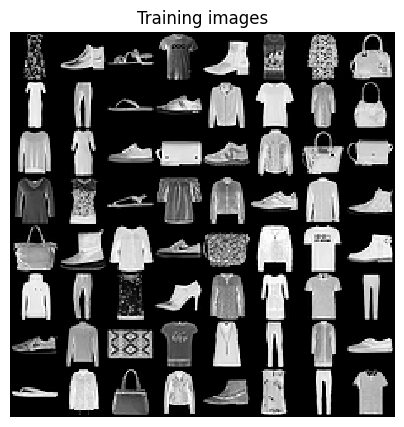

Labels = 
[[3 9 5 0 9 0 3 8]
 [3 1 5 7 4 0 3 8]
 [2 3 7 8 7 4 8 8]
 [2 6 5 6 4 7 6 7]
 [8 9 6 7 8 4 0 9]
 [2 1 6 9 6 3 0 1]
 [7 2 8 0 6 1 4 7]
 [5 4 8 4 9 6 1 0]]


In [3]:
import torchvision.utils as vutils

%matplotlib inline
import matplotlib.pyplot as plt

im_batch = next(iter(train_loader))
print('Mini_batch Dimensions: [B, C, H, W] = ')
print(im_batch[0].shape)
plt.figure(figsize=(5, 5))
plt.title("Training images")
plt.axis("off")
plt.imshow(
    np.transpose(
        vutils.make_grid(im_batch[0][:64], nrow=8, padding=1, normalize=True), (1, 2, 0)
    )
)
plt.show()
print("Labels = " )
print(im_batch[1][:64].data.numpy().reshape(8,-1))


### Noise Input for the Generator

Let us define a function which takes (batchsize, dimension) as input and returns a random noise of requested dimensions. This noise tensor will be the input to the generator.

In [4]:
def noise(bs, dim):
    """Generate random Gaussian noise vectors N(0,I), with mean 0 and variance 1.
    
    Inputs:
    - bs: integer giving the batch size of noise to generate.
    - dim: integer giving the dimension of the Gaussain noise to generate.
    
    Returns:
    A PyTorch Tensor containing Gaussian noise with shape [bs, dim]
    """
    
    out = (torch.randn((bs, dim)))
    out = out.to(device)
    return out

### Generator Architecture - 20 points

Define a Generator with the following architecture. 

- Linear layer (noise_dim -> 256)
- LeakyReLU (works well for the Generators, we will use negative_slope=2)
- Linear Layer (256 -> 512)
- LeakyReLU (negative slope 0.2)
- Linear Layer (512 -> 1024)
- LeakyReLU (negative slope 0.2)
- Linear Layer (1024 -> 784) (784 is the MNIST image size 28*28)
- TanH (To scale the generated images to [-1,1], the same as real images)

- LeakyRELU: https://pytorch.org/docs/stable/nn.html#leakyrelu 
- Fully connected layer: https://pytorch.org/docs/stable/nn.html#linear 
- TanH activation: https://pytorch.org/docs/stable/nn.html#tanh

In [5]:
class Generator(nn.Module):
    def __init__(self, noise_dim=100, out_size=784):
        super(Generator, self).__init__()
        
        ### BEGIN SOLUTION ###
        self.model = nn.Sequential(
            nn.Linear(noise_dim, 256),
            nn.LeakyReLU(2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, out_size),
            nn.Tanh()
        )
        ### END SOLUTION ###
        
        
        
    def forward(self, x):
        '''
        Make a forward pass of the input through the generator. Leaky relu is used as the activation 
        function in all the intermediate layers. Tanh activation function is only used at the end 
        
        Note that, generator takes a random noise as input and gives out fake "images". Hence, the Tensor 
        output after tanh activation function should be reshaped into the same size as the real images. i.e., 
        [batch_size, n_channels, H, W] == (batch_size, 1,28,28). You may use the .view(.) function to acheive it.
         
        '''
        ### BEGIN SOLUTION ###
        x = self.model(x)
        x = x.view(-1, 1, 28, 28)
        ### END SOLUTION ###
        
        return x
             

In [6]:
# Initialize the Generator and move it to GPU (if is_cuda)
generator = Generator()
print(generator)
# If you have a system with a GPU, you may want to install torchsummary and display the network in more detail 
# summary(generator,(100,), device='cpu')

# move to GPU
generator = generator.to(device)

Generator(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=2)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=1024, out_features=784, bias=True)
    (7): Tanh()
  )
)


### Discriminator Architecture - 20 points

Define a Discriminator with the following architecture. 

- Linear Layer (input_size -> 512)
- LeakyReLU (negative slope 0.2)
- Linear Layer (512 -> 256)
- LeakyReLU (negative slope 0.2)
- Linear Layer (256 -> 1)

In [7]:
## Similar to the Generator, we now define a Discriminator which takes in a vector and output a single scalar 
## value. 

class Discriminator(nn.Module):
    def __init__(self, input_size=784):
        super(Discriminator, self).__init__()
        
        ### BEGIN SOLUTION ###
        self.model = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
        )
        ### END SOLUTION ###
        
    
    def forward(self, x):
        '''
        The Discriminator takes a vectorized (dimension 28*28) input of the real and generated fake images. Reshape the input 
        to match the Discriminator architecture. You may use the .view(.) function to acheive it.
        Make a forward pass of the input through the Discriminator and return the scalar output of the 
        Discriminator.
        '''
        ### BEGIN SOLUTION ###
        x = x.view(-1, 784)
        x = self.model(x)
        ### END SOLUTION ###
        
        return x       
        

In [8]:
# Initialize the Discriminator and move it to GPU (if is_cuda)
discriminator = Discriminator()

print(discriminator)
# If you have a system with a GPU, you may want to install torchsummary and display the network in more detail 
# summary(discriminator,(784,), device='cpu')

# move to GPU
discriminator = discriminator.to(device)

Discriminator(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=256, out_features=1, bias=True)
  )
)


### Binary Cross Entropy Loss 

We will use the Binary cross entropy loss function to train the GAN. The loss function includes sigmoid activation followed by logistic loss. This allows us to distinguish between real and fake images.

Binary cross entropy loss with logits: https://pytorch.org/docs/stable/nn.html#bcewithlogitsloss

In [9]:
# Initialize the 'BCEWithLogitsLoss' object
bce_loss = nn.BCEWithLogitsLoss()

### Discriminator Loss  - 10 points

Let's define the objective function for the Discriminator. It takes as input the logits (outputs of the Discriminator) and the labels (real or fake). It uses the BCEWithLogitsLoss() to compute the loss in classification.

In [10]:
def DLoss(logits_real, logits_fake, targets_real, targets_fake):
    '''
    Returns the Binary Cross Entropy Loss between predictions and targets
    
    Inputs:
        logits_real: the outputs of the discriminator (before the sigmoid) for real images
        logits_fake: the outputs of the discriminator (before the sigmoid) for fake images
        targets_real: groundtruth labels for real images
        targets_fake: groundtruth labels for fake images
    
    '''
    # Concatenate the logits_real and the logits_fake using torch.cat() to get 'logits'
    # Concatenate the targets_real and the targets_fake using torch.cat() to get 'targets'
    # estimate the loss using the BCEWithLogitsLoss object 'bce' with 'logits' and 'targets'
    ### BEGIN SOLUTION ###
    logits = torch.cat((logits_real, logits_fake))
    targets = torch.cat((targets_real, targets_fake))
    loss = bce_loss(logits, targets)
    ### END SOLUTION ###
    return loss

### Generator Loss  - 10 points

Let's define the objective function for the Generator. It takes as input the logits (outputs of the Discriminator) for the fake images it has generated and the labels (real). It uses the BCEWithLogitsLoss() to compute the loss in classification. 
The Generator expects the logits for the fake images it has generated to be close to 1 (real). If that is not the case, the Generatro corrects itself with the loss

In [11]:
def GLoss(logits_fake, targets_real):
    '''
    The aim of the Generator is to fool the Discriminator into "thinking" the generated images are real.
    GLoss is the binary cross entropy loss between the outputs of the Discriminator with the 
    generated fake images 'logits_fake' and real targets 'targets_real'
    
    Inputs: 
        logits_fake: Logits from the Discriminator for the fake images generated by the Generator
        targets_real: groundtruth labels (close to 1) for the logits_fake
    '''
    # estimate the g_loss using the BCEWithLogitsLoss object 'bce' with 'logits_fake' and 'targets_real'
    ### BEGIN SOLUTION ###
    g_loss = bce_loss(logits_fake, targets_real)
    ### END SOLUTION ###
    
    return g_loss

### GAN Training - 40 points

Optimizers for training the Generator and the Discriminator. The below setup generates good images with the architecture. 
Feel free to adjust the optimizer settings. 

Adam optimizer: https://pytorch.org/docs/stable/optim.html#torch.optim.Adam

In [12]:
#The following settings generated realistic looking images. Feel free to adjust the settings.
epochs = 40
noise_dim = 100
LR = 0.0002
optimizer_G = torch.optim.Adam(generator.parameters(), lr=LR, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=LR, betas=(0.5, 0.999))

Epoch:   0
D Loss:  0.5903705358505249
G Loss:  1.0186755657196045


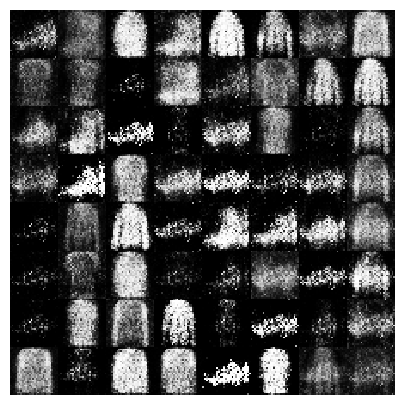

Epoch:   1
D Loss:  0.6050689220428467
G Loss:  1.043189287185669
Epoch:   2
D Loss:  0.6541663408279419
G Loss:  1.0090560913085938


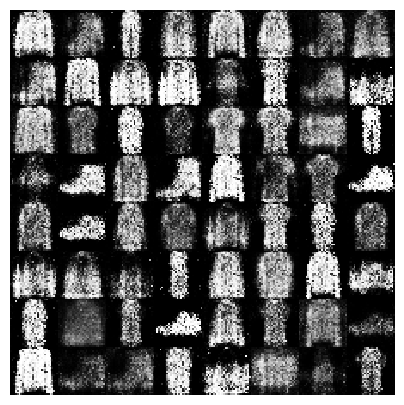

Epoch:   3
D Loss:  0.6782407760620117
G Loss:  0.9698206186294556
Epoch:   4
D Loss:  0.6980690956115723
G Loss:  1.036833643913269


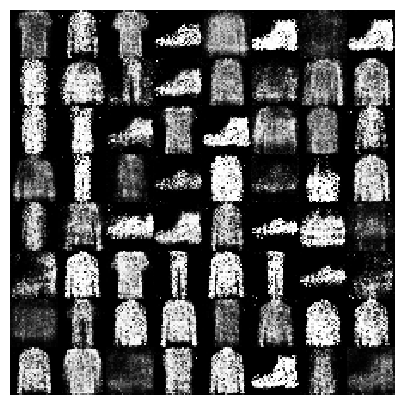

Epoch:   5
D Loss:  0.6518350839614868
G Loss:  0.9846437573432922
Epoch:   6
D Loss:  0.7126256227493286
G Loss:  0.9937976598739624


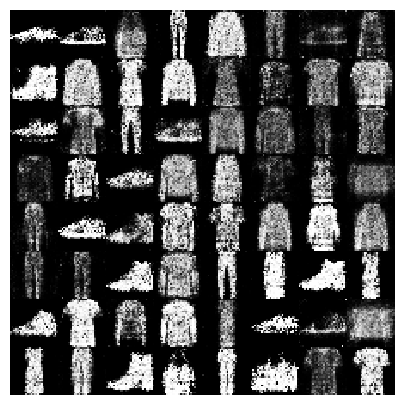

Epoch:   7
D Loss:  0.693540096282959
G Loss:  0.813178539276123
Epoch:   8
D Loss:  0.6770243644714355
G Loss:  0.8229242563247681


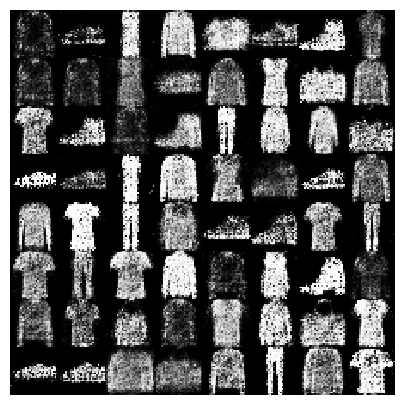

Epoch:   9
D Loss:  0.6727135181427002
G Loss:  0.8559591770172119
Epoch:   10
D Loss:  0.6719533205032349
G Loss:  0.839999258518219


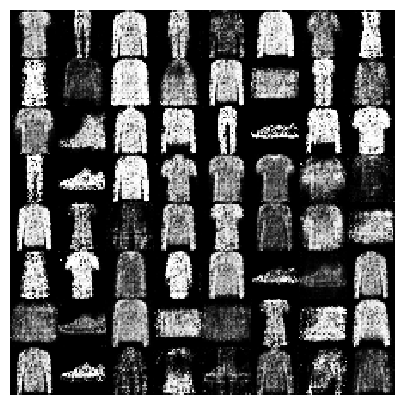

Epoch:   11
D Loss:  0.6550872325897217
G Loss:  0.8547855615615845
Epoch:   12
D Loss:  0.6652955412864685
G Loss:  0.783105731010437


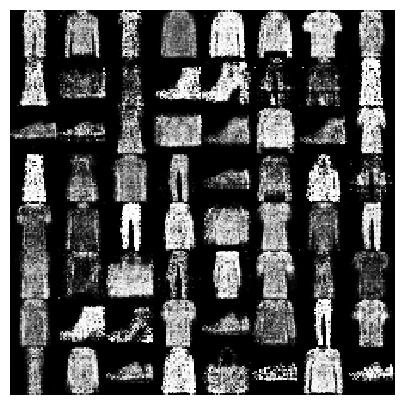

Epoch:   13
D Loss:  0.6719404458999634
G Loss:  0.8367561101913452
Epoch:   14
D Loss:  0.6843224167823792
G Loss:  0.8162457346916199


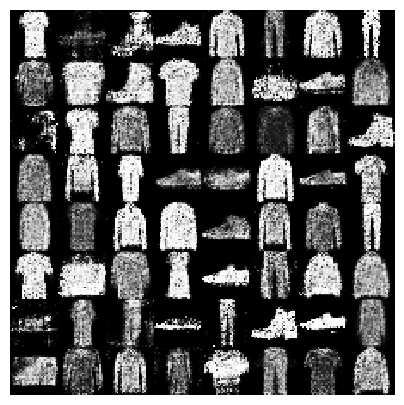

Epoch:   15
D Loss:  0.6587554216384888
G Loss:  0.8908952474594116
Epoch:   16
D Loss:  0.6787989139556885
G Loss:  0.9069045782089233


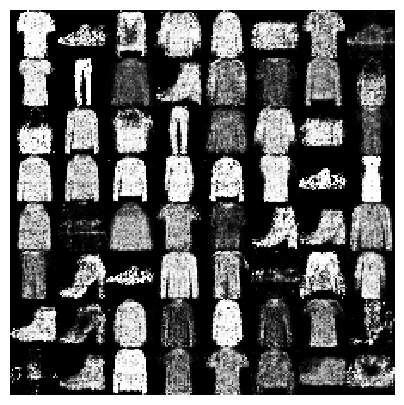

Epoch:   17
D Loss:  0.6663172245025635
G Loss:  0.89644455909729
Epoch:   18
D Loss:  0.6735292673110962
G Loss:  0.9649990797042847


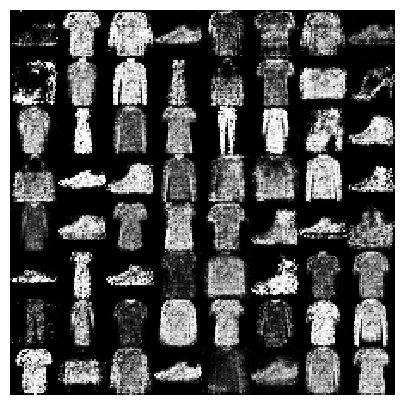

Epoch:   19
D Loss:  0.6373805999755859
G Loss:  0.907616376876831
Epoch:   20
D Loss:  0.6596932411193848
G Loss:  0.8449897170066833


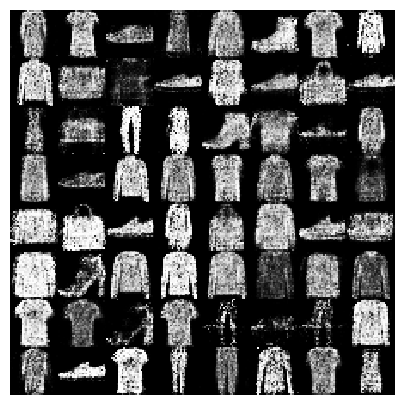

Epoch:   21
D Loss:  0.7032862305641174
G Loss:  0.8316961526870728
Epoch:   22
D Loss:  0.712307333946228
G Loss:  0.8531465530395508


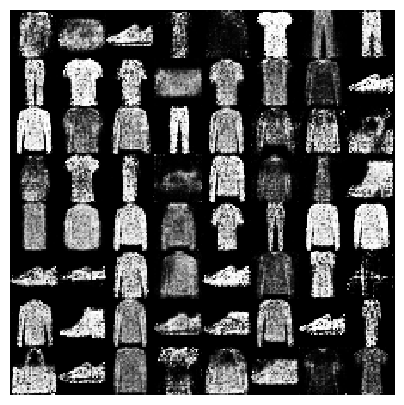

Epoch:   23
D Loss:  0.653084933757782
G Loss:  0.8986389636993408
Epoch:   24
D Loss:  0.6735447645187378
G Loss:  0.781100332736969


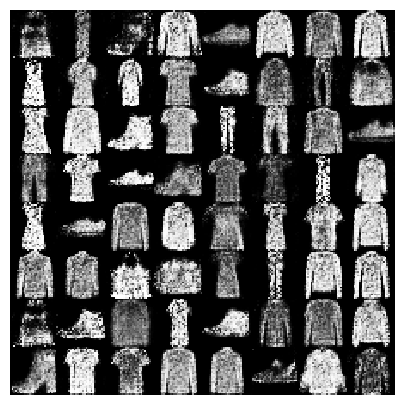

Epoch:   25
D Loss:  0.6744257807731628
G Loss:  0.9401094913482666
Epoch:   26
D Loss:  0.6355246305465698
G Loss:  0.8836681842803955


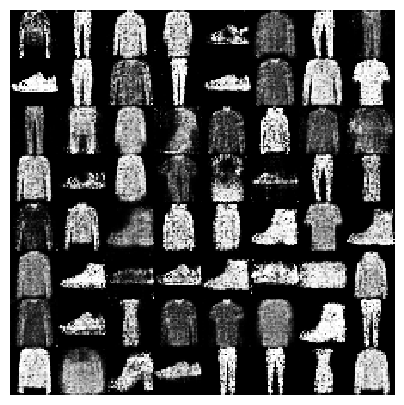

Epoch:   27
D Loss:  0.6550250053405762
G Loss:  0.8799775838851929
Epoch:   28
D Loss:  0.6697944402694702
G Loss:  0.8453668355941772


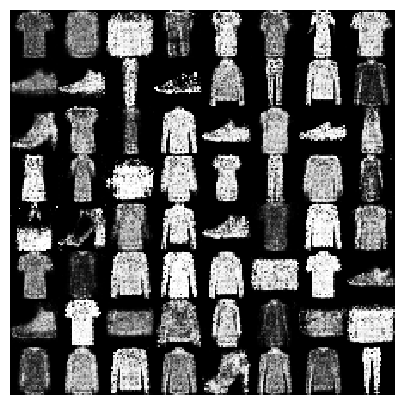

Epoch:   29
D Loss:  0.6532093286514282
G Loss:  0.9809730052947998
Epoch:   30
D Loss:  0.7187733054161072
G Loss:  0.8628982305526733


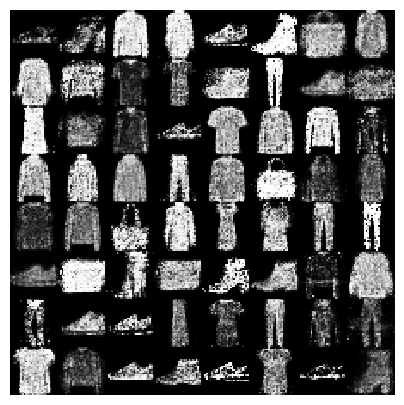

Epoch:   31
D Loss:  0.6608722805976868
G Loss:  0.8264734148979187
Epoch:   32
D Loss:  0.6854845881462097
G Loss:  1.027630090713501


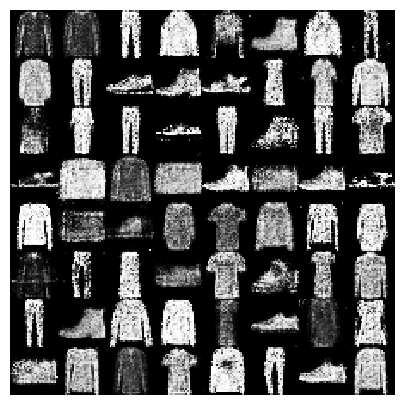

Epoch:   33
D Loss:  0.6639713048934937
G Loss:  0.9825505614280701
Epoch:   34
D Loss:  0.669124960899353
G Loss:  0.8914602994918823


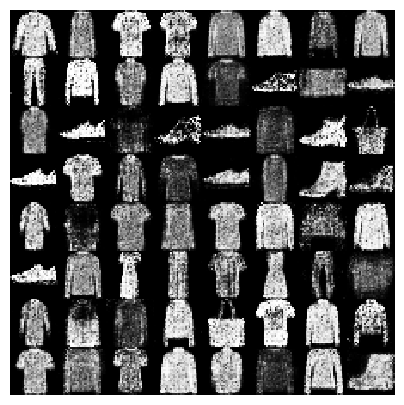

Epoch:   35
D Loss:  0.6694381237030029
G Loss:  0.9116557836532593
Epoch:   36
D Loss:  0.6615517139434814
G Loss:  0.8993431329727173


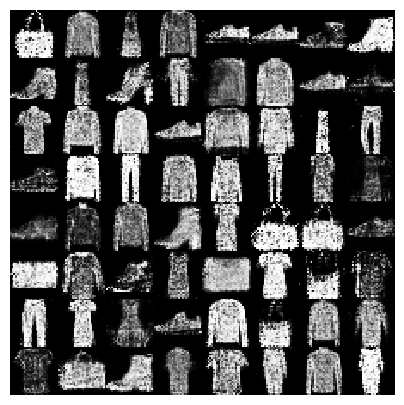

Epoch:   37
D Loss:  0.6549244523048401
G Loss:  0.9254870414733887
Epoch:   38
D Loss:  0.6243584156036377
G Loss:  0.8475024700164795


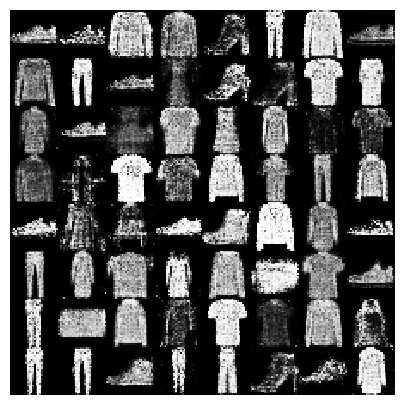

Epoch:   39
D Loss:  0.6766144037246704
G Loss:  0.9073367118835449


In [13]:
## Training loop

for epoch in range(epochs):
    for i, (images, _) in enumerate(train_loader):
        
        # We set targets_real and targets_fake to non-binary values (soft and noisy labels).
        # This is a hack for stable training of GAN's.  
        # GAN hacks: https://github.com/soumith/ganhacks#6-use-soft-and-noisy-labels
        
        targets_real = (torch.FloatTensor(images.size(0), 1).uniform_(0.8, 1.0))
        #targets_fake = (torch.FloatTensor(images.size(0), 1).uniform_(0.0, 0.2))
        targets_fake = torch.zeros(images.size(0), 1)
                
        targets_real = targets_real.to(device)
        targets_fake = targets_fake.to(device)
        images = images.to(device)
        
        ## D-STEP:
        ## First, clear the gradients of the Discriminator optimizer (.zero_grad()).
        ## Estimate logits_real by passing images through the Discriminator
        ## Generate fake_images by passing random noise through the Generator. Also, .detach() the fake images 
        ## as we don't compute the gradients of the Generator when optimizing Discriminator.
        ## fake_images = generator(noise(train_bs, noise_dim)).detach()
        ## Estimate logits_fake by passing the fake images through the Discriminator
        ## Compute the Discriminator loss by calling DLoss function.
        ## Compute the gradients by backpropagating (.backward()) through the computational graph. 
        ## Update the Discriminator parameters (.step()).
        
        
        ## G-STEP:
        ## clear the gradients of the Generator (.zero_grad()). 
        ## Generate fake images by passing random noise through the Generator. 
        ## Estimate logits_fake by passing the fake images through the Discriminator.
        ## compute the Generator loss by caling GLoss.
        ## compute the gradients by backpropagating (.backward()) through the computational graph.
        ## Update the Generator parameters (.step()). 
        
        ### BEGIN SOLUTION ###
        optimizer_D.zero_grad()

        logits_real = discriminator(images)
        fake_images = generator(noise(train_bs, noise_dim)).detach()
        logits_fake = discriminator(fake_images)

        discriminator_loss = DLoss(logits_real, logits_fake, targets_real, targets_fake)
        discriminator_loss.backward()
        optimizer_D.step()


        optimizer_G.zero_grad()

        fake_images = generator(noise(train_bs, noise_dim))
        logits_fake = discriminator(fake_images)

        generator_loss = GLoss(logits_fake, targets_real)
        generator_loss.backward()
        optimizer_G.step()
        ### END SOLUTION ###

    print("Epoch:  ", epoch)
    print("D Loss: ", discriminator_loss.item())
    print("G Loss: ", generator_loss.item())
          
    if epoch % 2 == 0:
        viz_batch = fake_images.data.cpu().numpy()
        viz_batch = viz_batch[:train_bs,:,:,:]
        viz_batch = viz_batch.reshape(-1,28*28).squeeze()
        viz_batch = viz_batch.reshape(-1,8,28,28).transpose(0,2,1,3).reshape(28*8,-1)

        plt.figure(figsize = (5,5))
        plt.axis('off')
        plt.imshow(viz_batch, cmap='gray')
        plt.show()